In [1]:
from llama_index.embeddings.langchain import LangchainEmbedding
from langchain.embeddings.huggingface import HuggingFaceEmbeddings

from llama_index.core.llama_pack.base import BaseLlamaPack
from llama_index.core import SimpleDirectoryReader

from llama_index.core.node_parser import SemanticSplitterNodeParser, SentenceSplitter
from llama_index.core.llms import ChatMessage
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core import Document, VectorStoreIndex, ServiceContext
from transformers import AutoTokenizer

import pymupdf4llm
from langchain.text_splitter import MarkdownTextSplitter

import numpy as np
import matplotlib.pyplot as plt

In [2]:
tokenizer = AutoTokenizer.from_pretrained("../Embeddings/bge-large-matryoshka/")

In [3]:
embeddings=LangchainEmbedding(
    HuggingFaceEmbeddings(model_name="../Embeddings/bge-large-matryoshka/")
)

In [4]:
# Create new service context instance
service_context = ServiceContext.from_defaults(
    chunk_size=512,
    llm=None,
    embed_model=embeddings
)

/tmp/ipykernel_8801/1395507778.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context = ServiceContext.from_defaults(


LLM is explicitly disabled. Using MockLLM.


In [5]:
# file_path =  '../Data/Os_books/Stallings.pdf'

In [6]:
# # Get the MD text
# md_text = pymupdf4llm.to_markdown(file_path)  # get markdown for all pages

In [7]:
# import os

# # Assuming file_path and md_text are defined
# file_name = os.path.splitext(os.path.basename(file_path))[0] + '.txt'

# with open(file_name, 'w') as file:
#     file.write(md_text)

In [8]:
file_names = ['Galvin.txt','Tanenbaum.txt', 'Stallings.txt']

In [9]:
documents = SimpleDirectoryReader(input_files=file_names).load_data()

In [10]:
len(documents)

3

In [12]:
index = VectorStoreIndex.from_documents(documents,service_context=service_context)

In [27]:
index.storage_context.persist("../Data/Index/")

In [24]:
query_engine = index.as_query_engine(similarity_top_k=5)

In [25]:
response = query_engine.query("Explain evolution of I/O functions")

In [26]:
print(response.response)

Context information is below.
---------------------
file_path: Stallings.txt

One way to tackle
this problem is multiprogramming, which, as we have seen, allows some processes to
be waiting on I/O operations while another process is executing. However, even
with the vast size of main memory in today’s machines, it will still often be the case
that I/O is not keeping up with the activities of the processor. Swapping is used to
bring in additional ready processes to keep the processor busy, but this in itself is an
I/O operation.Thus, a major effort in I/O design has been schemes for improving the
efficiency of the I/O.The area that has received the most attention, because of its importance, is disk I/O, and much of this chapter will be devoted to a study of disk I/O
efficiency.

The other major objective is **generality** . In the interests of simplicity and free-

dom from error, it is desirable to handle all devices in a uniform manner.This statement applies both to the way in which p

# Experimental 512 chunking 

In [9]:
splitter = SemanticSplitterNodeParser(
    buffer_size=1,
    breakpoint_percentile_threshold=95,
    embed_model=embeddings,
)

In [10]:
nodes = splitter.get_nodes_from_documents(documents)

In [11]:
content = []
for node in nodes:
    if(node.get_content() != '' and len(node.get_content().split()) > 50):
        content.append(node.get_content())

In [12]:
batches = [content[i:i+1024] for i in range(0, len(content), 1024)]

In [13]:
enc = []
for batch in batches:
    encs = tokenizer(batch,return_offsets_mapping=True,return_attention_mask=False)
    for i in range(len(batch)):
        enc.append(encs[i])

Token indices sequence length is longer than the specified maximum sequence length for this model (744 > 512). Running this sequence through the model will result in indexing errors


In [14]:
def split_encs(arr, chunk_size=512):
    """
    Splits a NumPy array into chunks of at most `chunk_size` elements.

    Parameters:
    arr (np.ndarray): The input array to split.
    chunk_size (int): The maximum size of each chunk.

    Returns:
    list of np.ndarray: A list of NumPy arrays, each with at most `chunk_size` elements.
    """
    # Calculate the number of chunks needed
    num_chunks = int(np.ceil(len(arr) / chunk_size))
    return [arr[i*chunk_size:(i+1)*chunk_size] for i in range(num_chunks)]

In [15]:
new_ids = []

In [16]:
for i in range(len(content)):
  new_ids.append(split_encs(np.array(enc[i].offsets)))

In [17]:
new_contents = []

In [18]:
new_ids[0][0][-1][1]

2419

In [19]:
for i in range(len(content)):
  ids = new_ids[i]
  ctx = content[i]
  for idx in ids:
    start = idx[0][1]
    end = idx[-1][1]
    sub_ctx = ctx[start:end]
    new_contents.append(sub_ctx)

In [20]:
lens  = [len(tokenizer.tokenize(ctx)) for ctx in new_contents]

In [21]:
idxs = np.where(np.array(lens) < 50)[0]

In [22]:
final_ctx = [item for idx, item in enumerate(new_contents) if idx not in idxs]

In [23]:
final_ctx[2]

'”\nof space and lack even a full-screen editor, whereas others require gigabytes\nof space and are based entirely on graphical windowing systems. A more common definition, and the one that we usually follow, is that the operating system\nis the one program running at all times on the computer—usually called the\n**kernel** . Along with the kernel, there are two other types of programs: **system**\n**programs** , which are associated with the operating system but are not necessarily part of the kernel, and application programs, which include all programs\nnot associated with the operation of the system.\n\nThe matter of what constitutes an operating system became increasingly\n\nimportant as personal computers became more widespread and operating systems grew increasingly sophisticated. In 1998, the United States Department of\nJustice filed suit against Microsoft, in essence claiming that Microsoft included\ntoo much functionality in its operating systems and thus prevented applicatio

In [24]:
from llama_index.core.schema import TextNode

In [25]:
final_nodes = []

In [26]:
nodes[0].metadata_template

'{key}: {value}'

In [27]:
for i,ctx in enumerate(final_ctx):
  final_nodes.append(TextNode(text=ctx,id_=i, metadata={'source': "Galvin"}))

In [28]:
service_context = ServiceContext.from_defaults(llm=None,embed_model=embeddings)

/tmp/ipykernel_5692/1198100181.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context = ServiceContext.from_defaults(llm=None,embed_model=embeddings)


LLM is explicitly disabled. Using MockLLM.


In [29]:
vs = VectorStoreIndex(nodes=final_nodes,service_context=service_context)

In [48]:
vs.storage_context.persist('../Data/Index/Galvin_index')

In [45]:
query_engine = vs.as_query_engine(similarity_top_k=1)


In [46]:
response = query_engine.query("Explain virtual file systems  ")

In [47]:
print(response.response)

Context information is below.
---------------------
source: Galvin

 mounted there. The
mount table entry contains a pointer to the superblock of the file system on
that device. This scheme enables the operating system to traverse its directory
structure, switching seamlessly among file systems of varying types.


**15.4** **File Sharing**

The ability to share files is very desirable for users who want to collaborate
and to reduce the effort required to achieve a computing goal. Therefore, useroriented operating systems must accommodate the need to share files in spite
of the inherent difficulties.

In this section, we examine more aspects of file sharing. We begin by

discussing general issues that arise when multiple users share files. Once
multiple users are allowed to share files, the challenge is to extend sharing to
multiple file systems, including remote file systems; we discuss that challenge
as well. Finally, we consider what to do about conflicting actions occurring on
share

In [ ]:
adef create_histogram(lengths, bins=10, title="Histogram of Lengths", xlabel="Length", ylabel="Frequency"):

    plt.hist(lengths, bins=bins, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

In [ ]:
np.array(lens).min()

0

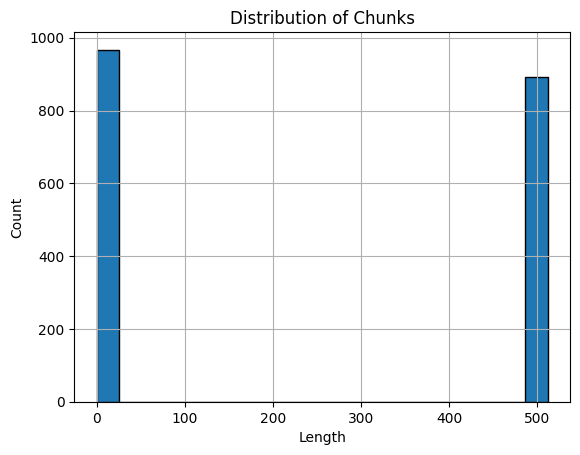

In [ ]:
create_histogram(lens, bins=20, title="Distribution of Chunks", xlabel="Length", ylabel="Count")

In [ ]:
np.array(lens).mean(), np.array(lens).max() , np.array(lens).min()

(1246.0028735632184, 7790, 401)

In [ ]:
nodes[0]

TextNode(id_='1e4c4699-ab27-4ff0-8c34-801587a4ad6e', embedding=None, metadata={'file_path': 'Galvin.txt', 'file_name': 'Galvin.txt', 'file_type': 'text/plain', 'file_size': 2993921, 'creation_date': '2024-06-25', 'last_modified_date': '2024-06-25'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='6f0289d6-0f1d-4fa3-89b2-ddf4733d8ccb', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': 'Galvin.txt', 'file_name': 'Galvin.txt', 'file_type': 'text/plain', 'file_size': 2993921, 'creation_date': '2024-06-25', 'last_modified_date': '2024-06-25'}, hash='2655c7bbb2a9716653089c20a7fbc179102413b83145929870e5f260a69dc900'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='825280de-0e33-4825-a839-3a17742